Epoch 0: Loss = 1.6957
Epoch 100: Loss = 0.5005
Epoch 200: Loss = 0.3473
Epoch 300: Loss = 0.2572
Epoch 400: Loss = 0.2073
Accuracy of edge prediction: 0.92


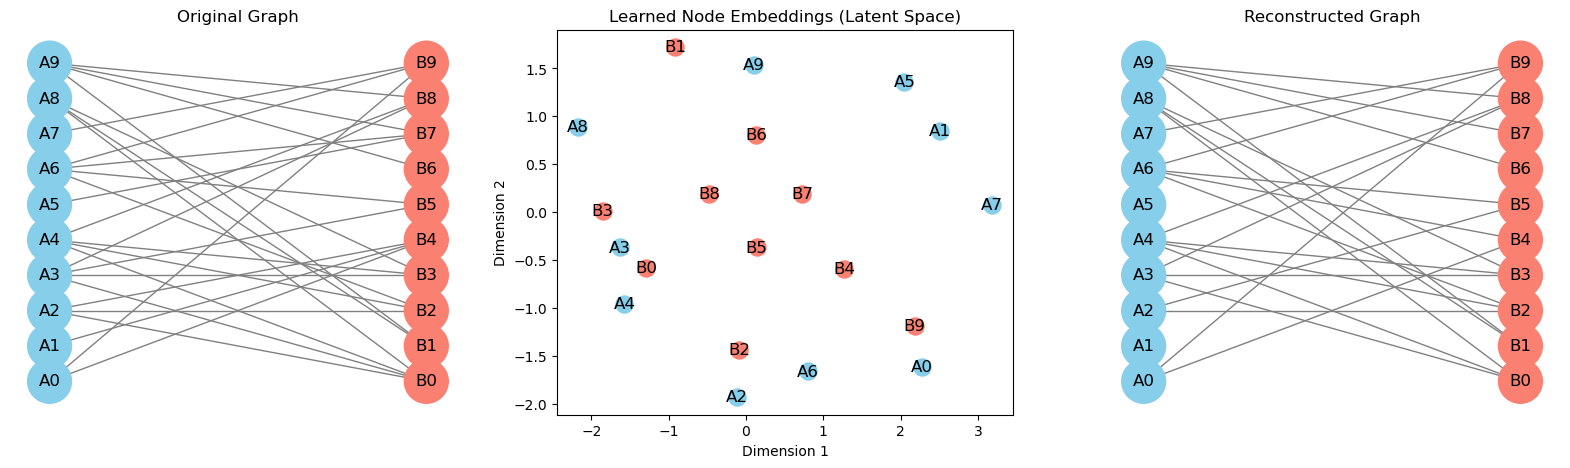

In [28]:
import networkx as nx
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np

# 1️ Generate Bipartite Graph
random.seed(99)
num_nodes_set_1 = 10  # Left column
num_nodes_set_2 = 10 # Right column

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
all_nodes = nodes_set_1 + nodes_set_2

G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)

edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.7:  # 50% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# 2️ Create the Data Matrix (Edge / Non-Edge Pairs)
datamatrix = []
for u in nodes_set_1:
    for v in nodes_set_2:
        label = 1 if (u, v) in edges or (v, u) in edges else 0
        u_idx = all_nodes.index(u)  # Convert node labels to indices
        v_idx = all_nodes.index(v)  # Convert node labels to indices
        datamatrix.append([label, u_idx, v_idx])  # Store indices instead of labels

datamatrix = np.array(datamatrix)

# Convert datamatrix to a PyTorch tensor
datamatrix_tensor = torch.tensor(datamatrix, dtype=torch.long)

# 3️ Prepare Training Data
positive_edges = torch.tensor([(all_nodes.index(u), all_nodes.index(v)) for u, v in edges])
negative_edges = torch.tensor([
    (random.randint(0, num_nodes_set_1 - 1), random.randint(num_nodes_set_1, len(all_nodes) - 1))
    for _ in range(len(positive_edges))
])

all_edges = torch.cat((positive_edges, negative_edges), dim=0)
labels = torch.cat((torch.ones(len(positive_edges)), torch.zeros(len(negative_edges)))).float()

# 4️ Define Embeddings (Random Initialization)
embedding_dim = 2
node_embeddings = torch.nn.Embedding(len(all_nodes), embedding_dim)
optimizer = torch.optim.Adam(node_embeddings.parameters(), lr=0.01)

# print(node_embeddings.weight)


def loss_function(z, datamatrix_tensor, alpha=1.0, eps=1e-8):
    sum_loss = 0
    for entry in datamatrix_tensor:
        label, u_idx, v_idx = entry
        z_u = z[u_idx]
        z_v = z[v_idx]
        prob = edge_probability(z_u, z_v, alpha)

        # Numerical stability: clamp probabilities to avoid log(0)
        prob = torch.clamp(prob, eps, 1 - eps)

        sum_loss += label.float() * torch.log(prob) + (1 - label.float()) * torch.log(1 - prob)

    return -sum_loss / len(datamatrix_tensor)


# 5️ Define Loss Function (Using Data Matrix)
def edge_probability(z_i, z_j, alpha=1.0):
    dist = torch.norm(z_i - z_j) ** 2  # Squared Euclidean distance using PyTorch
    return 1 / (1 + torch.exp(-alpha + dist))  # Logistic function using PyTorch


alpha = 3
# 6️ Train Embeddings
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    z = node_embeddings.weight  # Get embeddings
    loss = loss_function(z, datamatrix_tensor, alpha)  # Compute loss using datamatrix tensor
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


# 7️ Extract Final Embeddings
emb_matrix = node_embeddings.weight.detach()


# 8️ Reconstruct Graph Using Edge Probabilities
new_G = nx.Graph()
new_G.add_nodes_from(nodes_set_1, bipartite=0)
new_G.add_nodes_from(nodes_set_2, bipartite=1)

threshold = 0.5  # Edge threshold
prob_list = []
with torch.no_grad():
    for u in range(len(all_nodes)):
        for v in range(u + 1, len(all_nodes)):
            if (u in range(num_nodes_set_1) and v in range(num_nodes_set_1, len(all_nodes))) or \
               (v in range(num_nodes_set_1) and u in range(num_nodes_set_1, len(all_nodes))): 
                prob = edge_probability(emb_matrix[u], emb_matrix[v], alpha)
                prob_list.append(prob.item())
                if prob > threshold:
                    new_G.add_edge(all_nodes[u], all_nodes[v])

                # 8️ Compute Accuracy of Correctly Guessed Edges
                correct = 0
                total = 0

for u in nodes_set_1:
    for v in nodes_set_2:
        true_label = 1 if (u, v) in edges or (v, u) in edges else 0
        u_idx = all_nodes.index(u)
        v_idx = all_nodes.index(v)
        prob = edge_probability(emb_matrix[u_idx], emb_matrix[v_idx], alpha)
        pred_label = 1 if prob > threshold else 0
        if pred_label == true_label:
            correct += 1
        total += 1

accuracy = correct / total
print(f"Accuracy of edge prediction: {accuracy:.2f}")

# 9️ Plot Original Graph, Embeddings, and Reconstructed Graph
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})

# Plot Original Graph
nx.draw(G, pos, with_labels=True, node_size=1000, 
        node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], 
        edge_color="gray", ax=axes[0])
axes[0].set_title("Original Graph")

# Plot Learned Embeddings
emb_array = emb_matrix.numpy()
for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else 'salmon'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')

axes[1].set_title("Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

# Plot Reconstructed Graph
nx.draw(new_G, pos, with_labels=True, node_size=1000, 
        node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], 
        edge_color="gray", ax=axes[2])
axes[2].set_title("Reconstructed Graph")

plt.show()


Epoch 0: Loss = 1.3522
Epoch 100: Loss = 0.0817
Epoch 200: Loss = 0.0739
Epoch 300: Loss = 0.0728
Epoch 400: Loss = 0.0727
Accuracy of edge prediction: 1.00


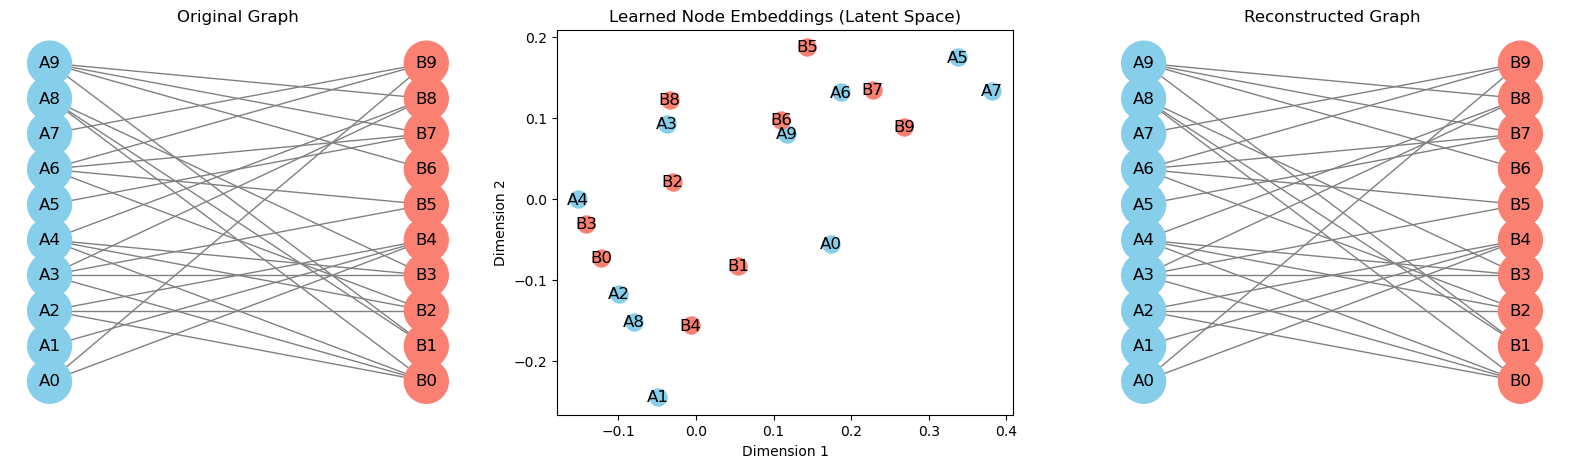

In [7]:
import networkx as nx
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# 1️⃣ Generate Bipartite Graph
random.seed(99)
num_nodes_set_1 = 10  # Left column
num_nodes_set_2 = 10  # Right column

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
all_nodes = nodes_set_1 + nodes_set_2

G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)

edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.7:  # 50% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# 2️⃣ Create the Data Matrix (Edge / Non-Edge Pairs)
datamatrix = []
for u in nodes_set_1:
    for v in nodes_set_2:
        label = 1 if (u, v) in edges or (v, u) in edges else 0
        u_idx = all_nodes.index(u)  # Convert node labels to indices
        v_idx = all_nodes.index(v)  # Convert node labels to indices
        datamatrix.append([label, u_idx, v_idx])  # Store indices instead of labels

datamatrix = np.array(datamatrix)

# Convert datamatrix to a PyTorch tensor
datamatrix_tensor = torch.tensor(datamatrix, dtype=torch.long)

# 3️⃣ Prepare Training Data
positive_edges = torch.tensor([(all_nodes.index(u), all_nodes.index(v)) for u, v in edges])
negative_edges = torch.tensor([
    (random.randint(0, num_nodes_set_1 - 1), random.randint(num_nodes_set_1, len(all_nodes) - 1))
    for _ in range(len(positive_edges))
])

all_edges = torch.cat((positive_edges, negative_edges), dim=0)
labels = torch.cat((torch.ones(len(positive_edges)), torch.zeros(len(negative_edges)))).float()

# 4️⃣ Define the GNN Model
class GCNLinkPrediction(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(GCNLinkPrediction, self).__init__()
        self.embedding_dim = embedding_dim
        self.conv1 = GCNConv(num_nodes, embedding_dim)  # First graph convolution layer
        self.conv2 = GCNConv(embedding_dim, embedding_dim)  # Second graph convolution layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))  # Apply first convolution and ReLU
        x = self.conv2(x, edge_index)  # Apply second convolution
        return x

# 5️⃣ Prepare the Data for GNN
edge_index = []
for u, v in edges:
    u_idx = all_nodes.index(u)
    v_idx = all_nodes.index(v)
    edge_index.append([u_idx, v_idx])

edge_index = torch.tensor(edge_index).t().contiguous()

# Create PyTorch Geometric Data object
x = torch.eye(len(all_nodes))  # Node features (identity matrix as placeholder)
data = Data(x=x, edge_index=edge_index)

# Initialize the model, optimizer, and loss function
embedding_dim = 128
model = GCNLinkPrediction(len(all_nodes), embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)


# 6️⃣ Define Loss Function (Edge Prediction Loss)
def edge_probability(z_i, z_j, alpha=1.0):
    """Compute the probability of an edge given embeddings."""
    dist = torch.norm(z_i - z_j) ** 2  # Squared Euclidean distance
    return 1 / (1 + torch.exp(-alpha + dist))  # Logistic function

def link_prediction_loss(z, datamatrix_tensor, alpha=1.0):
    """Compute the loss using the datamatrix tensor."""
    loss = 0
    for entry in datamatrix_tensor:
        label, u_idx, v_idx = entry  # Use indices directly
        z_u = z[u_idx]
        z_v = z[v_idx]
        
        # Compute edge probability
        prob = edge_probability(z_u, z_v, alpha)
        
        # Compute binary cross-entropy loss for this pair
        loss += F.binary_cross_entropy(prob, label.float())  # Apply loss using PyTorch
        
    return loss / len(datamatrix_tensor)

alpha = 3

# 7️⃣ Train the GNN Model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    z = model(data)  # Get embeddings from the GNN
    loss = link_prediction_loss(z, datamatrix_tensor, alpha)  # Compute loss
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# 8️⃣ Extract Final Embeddings
emb_matrix = z.detach()

# 9️⃣ Reconstruct Graph Using Edge Probabilities
new_G = nx.Graph()
new_G.add_nodes_from(nodes_set_1, bipartite=0)
new_G.add_nodes_from(nodes_set_2, bipartite=1)

threshold = 0.5  # Edge threshold
prob_list = []
with torch.no_grad():
    for u in range(len(all_nodes)):
        for v in range(u + 1, len(all_nodes)):
            if (u in range(num_nodes_set_1) and v in range(num_nodes_set_1, len(all_nodes))) or \
               (v in range(num_nodes_set_1) and u in range(num_nodes_set_1, len(all_nodes))): 
                prob = edge_probability(emb_matrix[u], emb_matrix[v], alpha)
                prob_list.append(prob.item())
                if prob > threshold:
                    new_G.add_edge(all_nodes[u], all_nodes[v])

# 10️⃣ Compute Accuracy of Correctly Guessed Edges
correct = 0
total = 0
for u in nodes_set_1:
    for v in nodes_set_2:
        true_label = 1 if (u, v) in edges or (v, u) in edges else 0
        u_idx = all_nodes.index(u)
        v_idx = all_nodes.index(v)
        prob = edge_probability(emb_matrix[u_idx], emb_matrix[v_idx], alpha)
        pred_label = 1 if prob > threshold else 0
        if pred_label == true_label:
            correct += 1
        total += 1

accuracy = correct / total
print(f"Accuracy of edge prediction: {accuracy:.2f}")

# 11️⃣ Plot Original Graph, Embeddings, and Reconstructed Graph
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})

# Plot Original Graph
nx.draw(G, pos, with_labels=True, node_size=1000, 
        node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], 
        edge_color="gray", ax=axes[0])
axes[0].set_title("Original Graph")

# Plot Learned Embeddings
emb_array = emb_matrix.numpy()
for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else 'salmon'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')

axes[1].set_title("Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

# Plot Reconstructed Graph
nx.draw(new_G, pos, with_labels=True, node_size=1000, 
        node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], 
        edge_color="gray", ax=axes[2])
axes[2].set_title("Reconstructed Graph")

plt.show()


In [8]:
prob_list

[0.0035174551885575056,
 5.114992291055387e-06,
 0.06507368385791779,
 1.700612119748257e-05,
 0.8313062191009521,
 0.009229592978954315,
 1.6996710705541318e-09,
 0.0010440933983772993,
 3.665237045424874e-06,
 0.831420361995697,
 0.005000552628189325,
 3.7568457855741144e-07,
 0.009830793365836143,
 1.4077342711971141e-05,
 0.9173295497894287,
 1.6215037248912267e-05,
 4.74081537915616e-12,
 6.69870473757328e-07,
 7.952846203806985e-08,
 0.011139553040266037,
 0.7479684352874756,
 0.002836473286151886,
 0.827871561050415,
 0.09046632796525955,
 0.8302856087684631,
 0.0214407816529274,
 4.205468030704651e-06,
 0.004150301683694124,
 0.011401154100894928,
 0.04911676049232483,
 0.7796351313591003,
 0.06310072541236877,
 0.1540186107158661,
 0.8740054965019226,
 0.0006806753226555884,
 0.737625777721405,
 0.005581745877861977,
 0.0314367301762104,
 0.7898961901664734,
 0.0011758640175685287,
 0.8951430916786194,
 0.06857988238334656,
 0.7479473352432251,
 0.821056604385376,
 0.008162943

Epoch 0: Loss = 0.7909
Epoch 100: Loss = 0.1899
Epoch 200: Loss = 0.1520
Epoch 300: Loss = 0.1414
Epoch 400: Loss = 0.0952
Test AUC Score: 0.5278


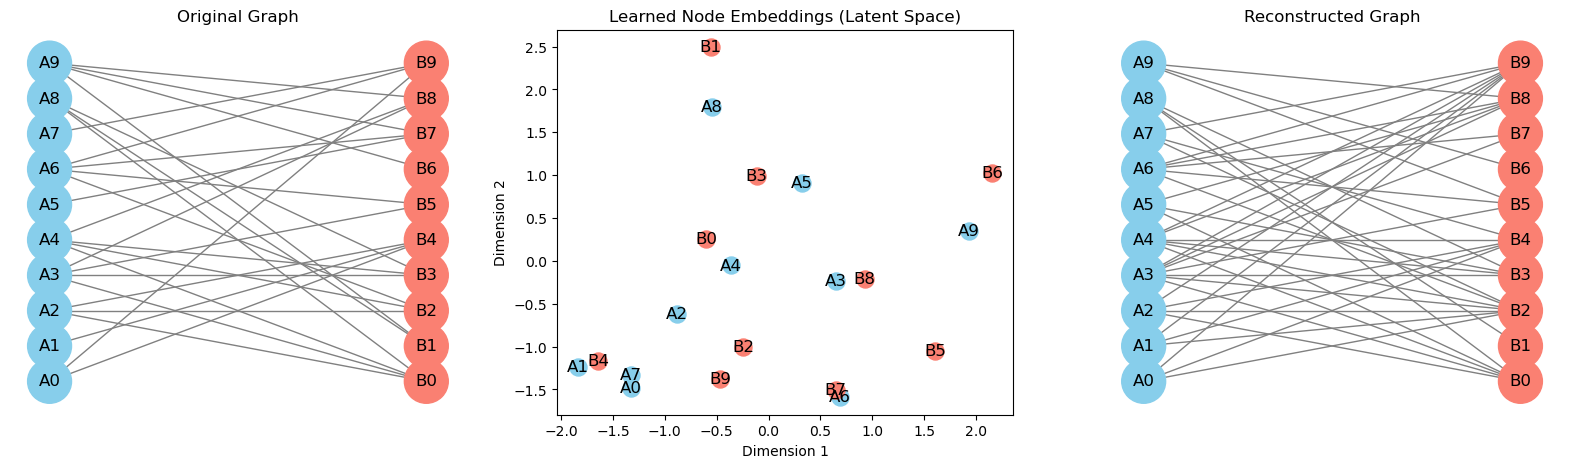

In [9]:
import networkx as nx
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score

# 1️⃣ Generate Bipartite Graph
random.seed(99)
num_nodes_set_1 = 10  # Left column
num_nodes_set_2 = 10  # Right column

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
all_nodes = nodes_set_1 + nodes_set_2

G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)

edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.7:  # 50% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# 2️⃣ Train-Test Split (80% Train, 20% Test)
random.shuffle(edges)
split_idx = int(len(edges) * 0.8)
train_edges = edges[:split_idx]
test_edges = edges[split_idx:]

# 3️⃣ Negative Sampling (Same Number as Positives)
def generate_negative_samples(existing_edges, num_samples):
    neg_edges = set()
    while len(neg_edges) < num_samples:
        u = random.choice(nodes_set_1)
        v = random.choice(nodes_set_2)
        if (u, v) not in existing_edges and (v, u) not in existing_edges:
            neg_edges.add((u, v))
    return list(neg_edges)

train_neg_edges = generate_negative_samples(train_edges, len(train_edges))
test_neg_edges = generate_negative_samples(test_edges, len(test_edges))

# Convert edges to PyTorch tensors
train_pos = torch.tensor([(all_nodes.index(u), all_nodes.index(v)) for u, v in train_edges])
train_neg = torch.tensor([(all_nodes.index(u), all_nodes.index(v)) for u, v in train_neg_edges])

test_pos = torch.tensor([(all_nodes.index(u), all_nodes.index(v)) for u, v in test_edges])
test_neg = torch.tensor([(all_nodes.index(u), all_nodes.index(v)) for u, v in test_neg_edges])

# Stack train and test edges with labels
train_edges_tensor = torch.cat((train_pos, train_neg), dim=0)
train_labels = torch.cat((torch.ones(len(train_pos)), torch.zeros(len(train_neg)))).float()

test_edges_tensor = torch.cat((test_pos, test_neg), dim=0)
test_labels = torch.cat((torch.ones(len(test_pos)), torch.zeros(len(test_neg)))).float()

# 4️⃣ Define Embeddings (Random Initialization)
embedding_dim = 2
node_embeddings = torch.nn.Embedding(len(all_nodes), embedding_dim)
optimizer = torch.optim.Adam(node_embeddings.parameters(), lr=0.01)

# 5️⃣ Define Loss Function
def edge_probability(z_i, z_j, alpha=1.0):
    """Compute the probability of an edge given embeddings."""
    dist = torch.norm(z_i - z_j) ** 2  # Squared Euclidean distance
    return 1 / (1 + torch.exp(-alpha + dist))  # Logistic function

def link_prediction_loss(z, edges, labels, alpha=1.0):
    """Compute the loss based on positive and negative samples."""
    loss = 0
    for (idx, (u_idx, v_idx)) in enumerate(edges):
        z_u = z[u_idx]
        z_v = z[v_idx]
        prob = edge_probability(z_u, z_v, alpha)
        loss += F.binary_cross_entropy(prob, labels[idx])  
    return loss / len(edges)

alpha = 3

# 6️⃣ Train Embeddings (Only on Train Data)
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    z = node_embeddings.weight  # Get embeddings
    loss = link_prediction_loss(z, train_edges_tensor, train_labels, alpha)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# 7️⃣ Extract Final Embeddings
emb_matrix = node_embeddings.weight.detach()

# 8️⃣ Evaluate on Test Set
with torch.no_grad():
    test_probs = torch.tensor([edge_probability(emb_matrix[u], emb_matrix[v], alpha) for u, v in test_edges_tensor])

# Compute AUC Score
auc_score = roc_auc_score(test_labels.numpy(), test_probs.numpy())
print(f"Test AUC Score: {auc_score:.4f}")

# 9️⃣ Plot Original Graph, Embeddings, and Reconstructed Graph
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})

# Plot Original Graph
nx.draw(G, pos, with_labels=True, node_size=1000, 
        node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], 
        edge_color="gray", ax=axes[0])
axes[0].set_title("Original Graph")

# Plot Learned Embeddings
emb_array = emb_matrix.numpy()
for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else 'salmon'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')

axes[1].set_title("Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

# Reconstruct Graph Using Edge Probabilities
new_G = nx.Graph()
new_G.add_nodes_from(nodes_set_1, bipartite=0)
new_G.add_nodes_from(nodes_set_2, bipartite=1)

threshold = 0.5  # Edge threshold
with torch.no_grad():
    for u in range(len(all_nodes)):
        for v in range(u + 1, len(all_nodes)):
            if (u in range(num_nodes_set_1) and v in range(num_nodes_set_1, len(all_nodes))) or \
               (v in range(num_nodes_set_1) and u in range(num_nodes_set_1, len(all_nodes))): 
                prob = edge_probability(emb_matrix[u], emb_matrix[v], alpha)
                if prob > threshold:
                    new_G.add_edge(all_nodes[u], all_nodes[v])

# Plot Reconstructed Graph
nx.draw(new_G, pos, with_labels=True, node_size=1000, 
        node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], 
        edge_color="gray", ax=axes[2])
axes[2].set_title("Reconstructed Graph")

plt.show()


Epoch 0: Loss = 1.4089
Epoch 100: Loss = 0.6060
Epoch 200: Loss = 0.5370
Epoch 300: Loss = 0.4948
Epoch 400: Loss = 0.4080
Test AUC Score: 0.5432


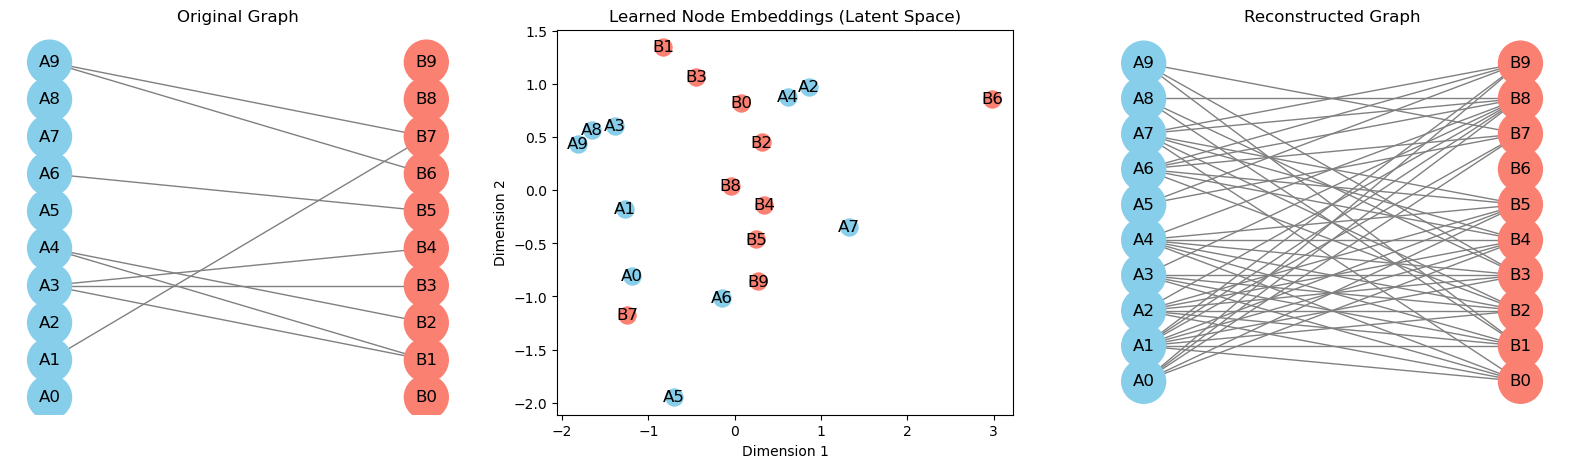

In [10]:
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data

# 1️⃣ Generate Bipartite Graph
random.seed(99)
num_nodes_set_1 = 10  # Left column
num_nodes_set_2 = 10  # Right column

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
all_nodes = nodes_set_1 + nodes_set_2



edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.5:  # 70% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# 2️⃣ Train-Test Split (80% Train, 20% Test)
random.shuffle(edges)
split_idx = int(len(edges) * 0.8)
train_edges = edges[:split_idx]
test_edges = edges[split_idx:]

# Create test graph
G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)
G.add_edges_from(test_edges)

# 3️⃣ Negative Sampling (Same Number as Positives)
def generate_negative_samples(existing_edges, num_samples):
    neg_edges = set()
    while len(neg_edges) < num_samples:
        u = random.choice(nodes_set_1)
        v = random.choice(nodes_set_2)
        if (u, v) not in existing_edges and (v, u) not in existing_edges:
            neg_edges.add((u, v))
    return list(neg_edges)

train_neg_edges = generate_negative_samples(train_edges, len(train_edges))
test_neg_edges = generate_negative_samples(test_edges, len(test_edges))

# Convert edges to PyTorch tensors
train_pos = torch.tensor([(all_nodes.index(u), all_nodes.index(v)) for u, v in train_edges])
train_neg = torch.tensor([(all_nodes.index(u), all_nodes.index(v)) for u, v in train_neg_edges])

test_pos = torch.tensor([(all_nodes.index(u), all_nodes.index(v)) for u, v in test_edges])
test_neg = torch.tensor([(all_nodes.index(u), all_nodes.index(v)) for u, v in test_neg_edges])

# Stack train and test edges with labels
train_edges_tensor = torch.cat((train_pos, train_neg), dim=0)
train_labels = torch.cat((torch.ones(len(train_pos)), torch.zeros(len(train_neg)))).float()

test_edges_tensor = torch.cat((test_pos, test_neg), dim=0)
test_labels = torch.cat((torch.ones(len(test_pos)), torch.zeros(len(test_neg)))).float()

# 4️⃣ Define GraphSAGE Model
class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_dim, out_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
    
    def forward(self, x, edge_index):
        # First GraphSAGE layer (aggregation from neighbors)
        x = F.relu(self.conv1(x, edge_index))
        # Second GraphSAGE layer (final embedding)
        x = self.conv2(x, edge_index)
        return x

# 5️⃣ Define Edge Probability Function
def edge_probability(z_i, z_j, alpha=1.0):
    dist = torch.norm(z_i - z_j) ** 2  # Squared Euclidean distance
    return 1 / (1 + torch.exp(-alpha + dist))  # Logistic function

def link_prediction_loss(z, edges, labels, alpha=1.0):
    loss = 0
    for idx in range(edges.size(1)):
        u_idx, v_idx = edges[:, idx]
        z_u = z[u_idx]
        z_v = z[v_idx]
        prob = edge_probability(z_u, z_v, alpha)
        loss += F.binary_cross_entropy(prob, labels[idx])  
    return loss / edges.size(1)

alpha = 3  # For edge probability calculation

# 6️⃣ Prepare for Training: Convert Data for PyTorch Geometric
node_features = torch.randn(len(all_nodes), 2)  # Random initial features for the nodes
train_edges_tensor = train_edges_tensor.T  # Convert edges to PyTorch Geometric format
data = Data(x=node_features, edge_index=train_edges_tensor)

# 7️⃣ Initialize the Model and Optimizer
model = GraphSAGE(num_features=2, hidden_dim=8, out_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 8️⃣ Train the Model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass through the model
    z = model(data.x, data.edge_index)  # Learned node embeddings
    
    # Compute the loss
    loss = link_prediction_loss(z, train_edges_tensor, train_labels, alpha)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# 9️⃣ Extract Final Embeddings
with torch.no_grad():
    model.eval()
    z = model(data.x, data.edge_index)  # Final learned embeddings

# 10️⃣ Evaluate on Test Set
with torch.no_grad():
    test_probs = torch.tensor([edge_probability(z[u], z[v], alpha) for u, v in test_edges_tensor])

# Compute AUC Score
auc_score = roc_auc_score(test_labels.numpy(), test_probs.numpy())
print(f"Test AUC Score: {auc_score:.4f}")

# 11️⃣ Plot Original Graph, Embeddings, and Reconstructed Graph
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})

# Plot Original Graph
nx.draw(G, pos, with_labels=True, node_size=1000, 
        node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], 
        edge_color="gray", ax=axes[0])
axes[0].set_title("Original Graph")

# Plot Learned Embeddings
emb_array = z.detach().numpy()
for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else 'salmon'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')

axes[1].set_title("Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

# Reconstruct Graph Using Edge Probabilities
new_G = nx.Graph()
new_G.add_nodes_from(nodes_set_1, bipartite=0)
new_G.add_nodes_from(nodes_set_2, bipartite=1)

threshold = 0.5  # Edge threshold
with torch.no_grad():
    for u in range(len(all_nodes)):
        for v in range(u + 1, len(all_nodes)):
            if (u in range(num_nodes_set_1) and v in range(num_nodes_set_1, len(all_nodes))) or \
               (v in range(num_nodes_set_1) and u in range(num_nodes_set_1, len(all_nodes))): 
                prob = edge_probability(z[u], z[v], alpha)
                if prob > threshold:
                    new_G.add_edge(all_nodes[u], all_nodes[v])

# Plot Reconstructed Graph
nx.draw(new_G, pos, with_labels=True, node_size=1000, 
        node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], 
        edge_color="gray", ax=axes[2])
axes[2].set_title("Reconstructed Graph")

plt.show()


Category Assignments:
B0 -> C1
B1 -> C2
B2 -> C2
B3 -> C2
B4 -> C0
B5 -> C2
B6 -> C3
B7 -> C2
B8 -> C2
B9 -> C3


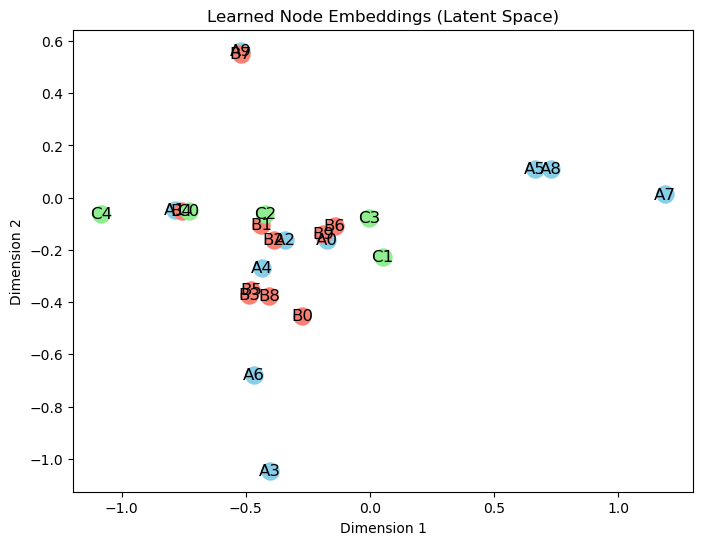

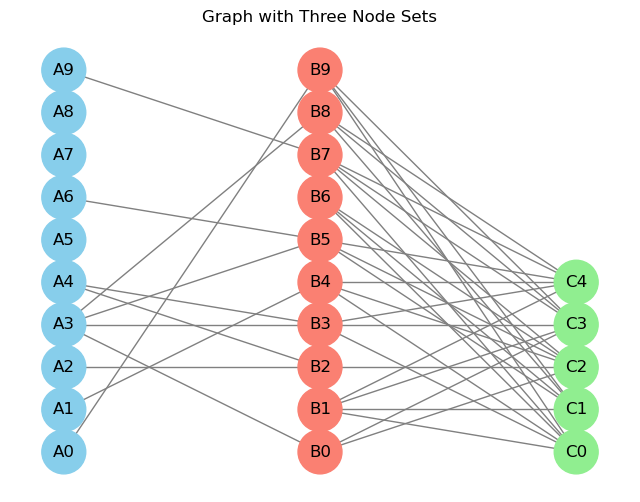

In [18]:
import networkx as nx
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np

# 1️ Generate Bipartite Graph with Three Columns
random.seed(99)
num_nodes_set_1 = 10  # Left column
num_nodes_set_2 = 10  # Middle column
num_nodes_set_3 = 5   # Right column (categories)

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
nodes_set_3 = [f"C{i}" for i in range(num_nodes_set_3)]
all_nodes = nodes_set_1 + nodes_set_2 + nodes_set_3

G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)
G.add_nodes_from(nodes_set_3, bipartite=2)

# Add edges between A and B
edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.9:  # 10% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# Add edges between B and C
edges_categorization = []
for u in nodes_set_2:
    for v in nodes_set_3:
        if random.random() > 0.6:  # 40% chance of an edge
            G.add_edge(u, v)
            edges_categorization.append((u, v))

# 2️ Define Embeddings
embedding_dim = 2
node_embeddings = torch.nn.Embedding(len(all_nodes), embedding_dim)
optimizer = torch.optim.Adam(node_embeddings.parameters(), lr=0.01)

def edge_probability(z_i, z_j, alpha=1.0):
    dist = torch.norm(z_i - z_j) ** 2
    return 1 / (1 + torch.exp(-alpha + dist))

# 3️ Train Embeddings
alpha = 3
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    z = node_embeddings.weight  # Get embeddings
    loss = 0
    
    for u, v in edges + edges_categorization:
        u_idx, v_idx = all_nodes.index(u), all_nodes.index(v)
        z_u, z_v = z[u_idx], z[v_idx]
        prob = edge_probability(z_u, z_v, alpha)
        loss -= torch.log(prob + 1e-8)
    
    loss.backward()
    optimizer.step()

# 4️ Assign B nodes to C nodes using Softmax on Distance
emb_matrix = node_embeddings.weight.detach()
category_assignments = {}

for b in nodes_set_2:
    b_idx = all_nodes.index(b)
    distances = []
    
    for c in nodes_set_3:
        c_idx = all_nodes.index(c)
        dist = torch.norm(emb_matrix[b_idx] - emb_matrix[c_idx])
        distances.append(-dist.item())  # Negative for softmax
    
    probs = F.softmax(torch.tensor(distances), dim=0)
    assigned_c = nodes_set_3[torch.argmax(probs).item()]
    category_assignments[b] = assigned_c

# 5️ Print Assignments
print("Category Assignments:")
for b, c in category_assignments.items():
    print(f"{b} -> {c}")

#plot latent space
# 5️ Plot Latent Space
emb_array = emb_matrix.numpy()
fig, ax = plt.subplots(figsize=(8, 6))
for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else ('salmon' if node in nodes_set_2 else 'lightgreen')
    ax.scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    ax.text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')

plt.title("Learned Node Embeddings (Latent Space)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

# 6️ Plot Graph with Category Labels
fig, ax = plt.subplots(figsize=(8, 6))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})
pos.update({node: (2, i) for i, node in enumerate(nodes_set_3)})

colors = ['skyblue' if n in nodes_set_1 else ('salmon' if n in nodes_set_2 else 'lightgreen') for n in G.nodes()]
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=colors, edge_color="gray", ax=ax)
plt.title("Graph with Three Node Sets")
plt.show()

Category Assignments:
B0 -> C4
B1 -> C0
B2 -> C2
B3 -> C4
B4 -> C0
B5 -> C4
B6 -> C0
B7 -> C0
B8 -> C0
B9 -> C0


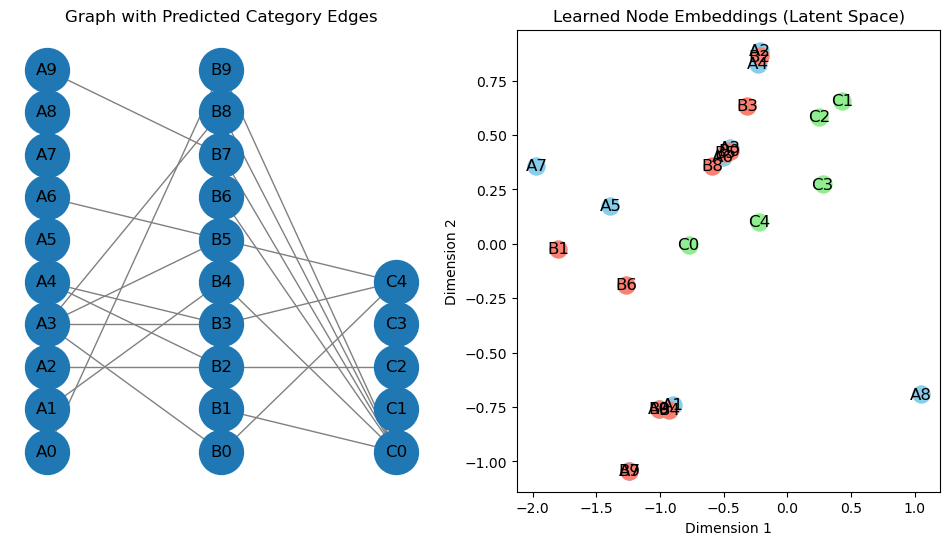

In [16]:
import networkx as nx
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np

# 1️ Generate Bipartite Graph with Two Columns and Predicted Edges
random.seed(99)
num_nodes_set_1 = 10  # Left column
num_nodes_set_2 = 10  # Middle column
num_nodes_set_3 = 5   # Right column (categories)

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
nodes_set_3 = [f"C{i}" for i in range(num_nodes_set_3)]
all_nodes = nodes_set_1 + nodes_set_2 + nodes_set_3

G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)
G.add_nodes_from(nodes_set_3, bipartite=2)

# Add edges between A and B
edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.9:  # 10% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# 2️ Define Embeddings
embedding_dim = 2
node_embeddings = torch.nn.Embedding(len(all_nodes), embedding_dim)
optimizer = torch.optim.Adam(node_embeddings.parameters(), lr=0.01)

def edge_probability(z_i, z_j, alpha=1.0):
    dist = torch.norm(z_i - z_j) ** 2
    return 1 / (1 + torch.exp(-alpha + dist))

# 3️ Train Embeddings
alpha = 3
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    z = node_embeddings.weight  # Get embeddings
    loss = 0
    
    for u, v in edges:
        u_idx, v_idx = all_nodes.index(u), all_nodes.index(v)
        z_u, z_v = z[u_idx], z[v_idx]
        prob = edge_probability(z_u, z_v, alpha)
        loss -= torch.log(prob + 1e-8)
    
    loss.backward()
    optimizer.step()

# 4️ Assign B nodes to C nodes using Shortest Latent Space Distance
emb_matrix = node_embeddings.weight.detach()
category_assignments = {}
predicted_edges = []

for b in nodes_set_2:
    b_idx = all_nodes.index(b)
    distances = []
    
    for c in nodes_set_3:
        c_idx = all_nodes.index(c)
        dist = torch.norm(emb_matrix[b_idx] - emb_matrix[c_idx])
        distances.append((dist.item(), c))
    
    assigned_c = min(distances, key=lambda x: x[0])[1]  # Get C with shortest distance
    category_assignments[b] = assigned_c
    predicted_edges.append((b, assigned_c))
    G.add_edge(b, assigned_c)  # Add edge to graph

# 5️ Print Assignments
print("Category Assignments:")
for b, c in category_assignments.items():
    print(f"{b} -> {c}")

# 6️ Plot Graph with Category Labels
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})
pos.update({node: (2, i) for i, node in enumerate(nodes_set_3)})
colors = ['skyblue' if n in nodes_set_1 else 'salmon' if n in nodes_set_2 else 'lightgreen' for n in G.nodes()]
nx.draw(G, pos, with_labels=True, node_size=1000, edge_color="gray", ax=axes[0])
axes[0].set_title("Graph with Predicted Category Edges")

# 7️ Plot Latent Space
emb_array = emb_matrix.numpy()
for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else 'salmon' if node in nodes_set_2 else 'lightgreen'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')
axes[1].set_title("Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

plt.show()


True Category Assignments:
B0 -> C3
B1 -> C3
B2 -> C1
B3 -> C4
B4 -> C1
B5 -> C1
B6 -> C1
B7 -> C1
B8 -> C0
B9 -> C2
Epoch 0: Loss = 1.0548
Epoch 100: Loss = 0.2290
Epoch 200: Loss = 0.1321
Epoch 300: Loss = 0.0931
Epoch 400: Loss = 0.0514
Category Prediction Accuracy: 0.1000


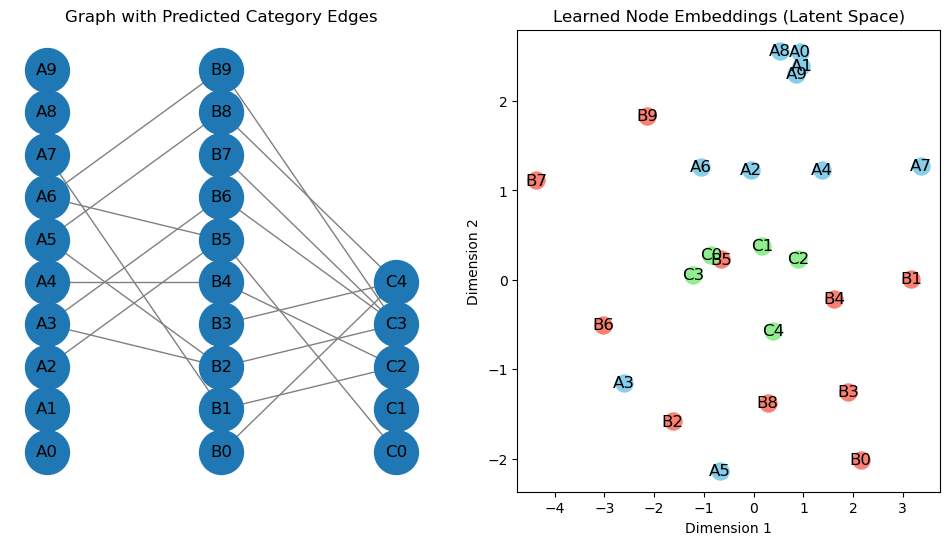

In [ ]:
import networkx as nx
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np

# 1️ Generate Bipartite Graph with Known Category Assignments
random.seed(99)
num_nodes_set_1 = 10  # Left column (A nodes)
num_nodes_set_2 = 10  # Middle column (B nodes)
num_nodes_set_3 = 5   # Right column (C nodes, predefined categories)

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
nodes_set_3 = [f"C{i}" for i in range(num_nodes_set_3)]
all_nodes = nodes_set_1 + nodes_set_2 + nodes_set_3

# Predefine category assignments for B nodes
true_categories = {nodes_set_2[i]: random.choice(nodes_set_3) for i in range(num_nodes_set_2)}
print("True Category Assignments:")
for b, c in true_categories.items():
    print(f"{b} -> {c}")

G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)
G.add_nodes_from(nodes_set_3, bipartite=2)

# Add edges between A and B
edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.9:  # 10% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# 2️ Create the Data Matrix (Edge / Non-Edge Pairs)
datamatrix = []
for u in nodes_set_1:
    for v in nodes_set_2:
        label = 1 if (u, v) in edges or (v, u) in edges else 0
        u_idx = all_nodes.index(u)  # Convert node labels to indices
        v_idx = all_nodes.index(v)  # Convert node labels to indices
        datamatrix.append([label, u_idx, v_idx])  # Store indices instead of labels

datamatrix = np.array(datamatrix)

# Convert datamatrix to a PyTorch tensor
datamatrix_tensor = torch.tensor(datamatrix, dtype=torch.long)

# 2️ Define Embeddings
embedding_dim = 2
node_embeddings = torch.nn.Embedding(len(all_nodes), embedding_dim)
optimizer = torch.optim.Adam(node_embeddings.parameters(), lr=0.01)

# 3️ Train Embeddings
alpha = 3
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    z = node_embeddings.weight  # Get embeddings
    loss = loss_function(z, datamatrix_tensor, alpha, eps=1E-10)  # Compute loss
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# 4️ Assign B nodes to C nodes using Shortest Latent Space Distance
emb_matrix = node_embeddings.weight.detach()
predicted_categories = {}
predicted_edges = []

for b in nodes_set_2:
    b_idx = all_nodes.index(b)
    distances = []
    
    for c in nodes_set_3:
        c_idx = all_nodes.index(c)
        dist = torch.norm(emb_matrix[b_idx] - emb_matrix[c_idx])
        distances.append((dist.item(), c))
    
    assigned_c = min(distances, key=lambda x: x[0])[1]  # Get C with shortest distance
    predicted_categories[b] = assigned_c
    predicted_edges.append((b, assigned_c))
    G.add_edge(b, assigned_c)  # Add edge to graph

# 5️ Compute Accuracy of Category Prediction
correct = sum(1 for b in nodes_set_2 if predicted_categories[b] == true_categories[b])
accuracy = correct / len(nodes_set_2)
print(f"Category Prediction Accuracy: {accuracy:.4f}")

# 6️ Plot Graph with Category Labels
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})
pos.update({node: (2, i) for i, node in enumerate(nodes_set_3)})
nx.draw(G, pos, with_labels=True, node_size=1000, edge_color="gray", ax=axes[0])
axes[0].set_title("Graph with Predicted Category Edges")

# 7️ Plot Latent Space
emb_array = emb_matrix.numpy()
for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else 'salmon' if node in nodes_set_2 else 'lightgreen'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')
axes[1].set_title("Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

plt.show()

In [17]:
# Create graph
G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)  # A nodes
G.add_nodes_from(nodes_set_2, bipartite=1)  # B nodes
G.add_nodes_from(nodes_set_3, bipartite=2)  # C nodes

# Add only A → B edges for training
edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.9:
            G.add_edge(u, v)
            edges.append((u, v))



# Define Embeddings
embedding_dim = 2
node_embeddings = torch.nn.Embedding(len(all_nodes), embedding_dim)
optimizer = torch.optim.Adam(node_embeddings.parameters(), lr=0.01)

# Loss function for A → B edge training
def loss_function(embeddings, edges):
    total_loss = 0
    for u, v in edges:
        u_idx = all_nodes.index(u)
        v_idx = all_nodes.index(v)
        z_u = embeddings[u_idx]
        z_v = embeddings[v_idx]

        # Using cosine similarity
        sim = F.cosine_similarity(z_u.unsqueeze(0), z_v.unsqueeze(0)).squeeze()
        total_loss += -torch.log(sim + 1e-8)

    return total_loss / len(edges)

# Training loop (Only on A → B edges)
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    z = node_embeddings.weight
    loss = loss_function(z, edges)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Get final trained embeddings
emb_matrix = node_embeddings.weight.detach()

predicted_categories = {}
for b in nodes_set_2:
    b_idx = all_nodes.index(b)
    similarities = []

    for c in nodes_set_3:
        c_idx = all_nodes.index(c)
        sim = F.cosine_similarity(emb_matrix[b_idx].unsqueeze(0), emb_matrix[c_idx].unsqueeze(0)).item()
        similarities.append((sim, c))

    assigned_c = max(similarities, key=lambda x: x[0])[1]  # Choose most similar C
    predicted_categories[b] = assigned_c

correct = sum(1 for b in nodes_set_2 if predicted_categories[b] == true_categories[b])
accuracy = correct / len(nodes_set_2)
print(f"Category Prediction Accuracy: {accuracy:.4f}")


Epoch 0: Loss = nan
Epoch 100: Loss = nan
Epoch 200: Loss = nan
Epoch 300: Loss = nan
Epoch 400: Loss = nan


NameError: name 'true_categories' is not defined

True Category Assignments:
B0 -> C3
B1 -> C3
B2 -> C1
B3 -> C4
B4 -> C1
B5 -> C1
B6 -> C1
B7 -> C1
B8 -> C0
B9 -> C2
Epoch 0: Loss = 1.3097
Epoch 100: Loss = 0.2391
Epoch 200: Loss = 0.0031
Epoch 300: Loss = 0.0021
Epoch 400: Loss = 0.0017
Category Prediction Accuracy: 1.0000
New node B_new is classified as: C4


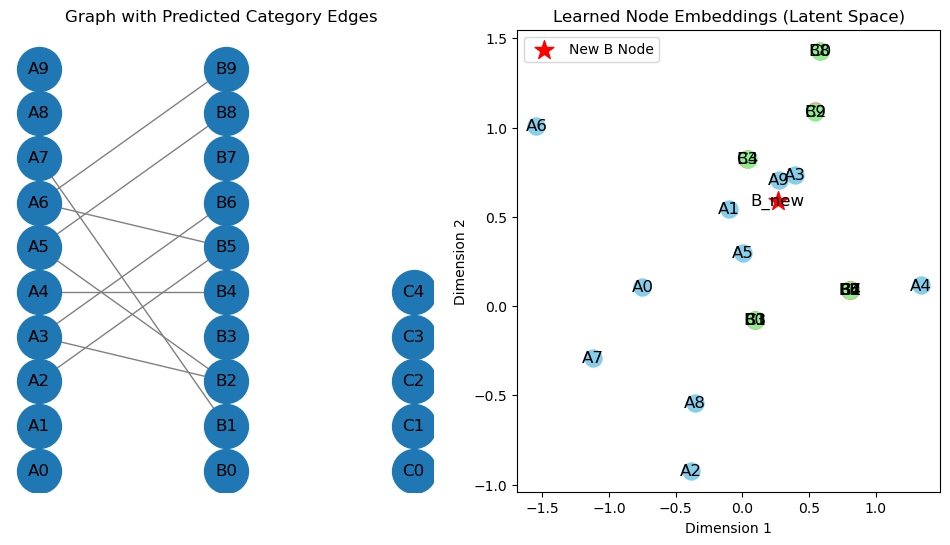

In [26]:
import networkx as nx
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np

# 1️ Generate Bipartite Graph with Known Category Assignments
random.seed(99)
num_nodes_set_1 = 10  # Left column (A nodes)
num_nodes_set_2 = 10  # Middle column (B nodes)
num_nodes_set_3 = 5   # Right column (C nodes, predefined categories)

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
nodes_set_3 = [f"C{i}" for i in range(num_nodes_set_3)]
all_nodes = nodes_set_1 + nodes_set_2 + nodes_set_3

# Predefine category assignments for B nodes
true_categories = {nodes_set_2[i]: random.choice(nodes_set_3) for i in range(num_nodes_set_2)}
print("True Category Assignments:")
for b, c in true_categories.items():
    print(f"{b} -> {c}")

G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)
G.add_nodes_from(nodes_set_3, bipartite=2)

# Add edges between A and B
edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.9:  # 10% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# 2️ Define Embeddings
embedding_dim = 2
node_embeddings = torch.nn.Embedding(len(all_nodes), embedding_dim)
optimizer = torch.optim.Adam(node_embeddings.parameters(), lr=0.01)

# 3️ Define Loss Function to Place B Nodes Near Their True C Nodes
def loss_function(embeddings, true_categories, all_nodes):
    loss = 0
    for b, c in true_categories.items():
        b_idx = all_nodes.index(b)
        c_idx = all_nodes.index(c)
        loss += torch.norm(embeddings[b_idx] - embeddings[c_idx])  # Minimize distance
    return loss / len(true_categories)  # Normalize

# 4️ Train Embeddings
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    emb_matrix = node_embeddings.weight  # Get embeddings
    loss = loss_function(emb_matrix, true_categories, all_nodes)  # Compute loss
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# 5️ Assign B Nodes to C Nodes Using Learned Embeddings
emb_matrix = node_embeddings.weight.detach()
predicted_categories = {}

for b in nodes_set_2:
    b_idx = all_nodes.index(b)
    distances = [(torch.norm(emb_matrix[b_idx] - emb_matrix[all_nodes.index(c)]).item(), c) for c in nodes_set_3]
    predicted_categories[b] = min(distances, key=lambda x: x[0])[1]  # Assign closest C-node

# 6️ Compute Accuracy
correct = sum(1 for b in nodes_set_2 if predicted_categories[b] == true_categories[b])
accuracy = correct / len(nodes_set_2)
print(f"Category Prediction Accuracy: {accuracy:.4f}")

# 7️ Add a New B Node and Classify It
new_b = "B_new"
all_nodes.append(new_b)
new_b_idx = len(all_nodes) - 1

# Initialize embedding based on random A-node connections (if available)
connected_as = [random.choice(nodes_set_1) for _ in range(random.randint(1, 3))]
connected_a_idxs = torch.tensor([all_nodes.index(a) for a in connected_as])

if len(connected_as) > 0:
    new_b_embedding = node_embeddings(connected_a_idxs).mean(dim=0)  # Mean of connected A-node embeddings
else:
    new_b_embedding = torch.randn(embedding_dim)  # Random initialization

# Find closest C-node for classification
distances = [(torch.norm(new_b_embedding - emb_matrix[all_nodes.index(c)]).item(), c) for c in nodes_set_3]
assigned_c_new = min(distances, key=lambda x: x[0])[1]
print(f"New node {new_b} is classified as: {assigned_c_new}")

# 8️ Plot Graph with Category Labels
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})
pos.update({node: (2, i) for i, node in enumerate(nodes_set_3)})
nx.draw(G, pos, with_labels=True, node_size=1000, edge_color="gray", ax=axes[0])
axes[0].set_title("Graph with Predicted Category Edges")

# 9️ Plot Latent Space
emb_array = emb_matrix.numpy()
for idx, node in enumerate(all_nodes[:-1]):  # Exclude new node for now
    color = 'skyblue' if node in nodes_set_1 else 'salmon' if node in nodes_set_2 else 'lightgreen'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')

# Plot new node
axes[1].scatter(new_b_embedding[0].item(), new_b_embedding[1].item(), c="red", s=200, marker="*", label="New B Node")
axes[1].text(new_b_embedding[0].item(), new_b_embedding[1].item(), new_b, fontsize=12, ha='center', va='center')
axes[1].legend()
axes[1].set_title("Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

plt.show()
